In [1]:
# !pip install folium

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians # radians = 파이/180 ex)math.radians(360) = 파이/180*360 = 2파이 = 2*3.14

from folium import FeatureGroup, LayerControl, Map, Marker #folium: 엷은층
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')

import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

In [2]:
train=pd.read_csv("./input/train.csv")
test=pd.read_csv("./input/test.csv")
test.shape

(625134, 9)

In [3]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Convert to appropriate datatype 

픽업 날짜/시간 및 하차 날짜/시간을 날짜-시간 개체로 변환

In [4]:
train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime']=pd.to_datetime(train['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


###  Are there any missing values in the data?

In [5]:
train[pd.isnull(train)].sum()

id                    0  
vendor_id             0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0  
trip_duration         0.0
dtype: object

There are no missing values

### What is the time period of the dataset?

In [6]:
# 날짜 기간 확인
print("Min pickup time:", min(train['pickup_datetime']))
print("Max pickup time:", max(train['pickup_datetime']))

Min pickup time: 2016-01-01 00:00:17
Max pickup time: 2016-06-30 23:59:39


The data has 6 months of taxi trip data, from Jan to Jun 2016

### create new day,month, hour info from Pickup time

In [7]:
train['pickup_date']= train['pickup_datetime'].dt.date
train['pickup_day']=train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour']=train['pickup_datetime'].apply(lambda x:x.hour)
train['pickup_day_of_week']=train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
train['dropoff_date']= train['dropoff_datetime'].dt.date
train['dropoff_day']=train['dropoff_datetime'].apply(lambda x:x.day)
train['dropoff_hour']=train['dropoff_datetime'].apply(lambda x:x.hour)
train['dropoff_day_of_week']=train['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

In [8]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday


### Round(반올림) lat lng to 3 decimal places

In [9]:
train['pickup_latitude_round3']=train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude_round3']=train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3']=train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3']=train['dropoff_longitude'].apply(lambda x:round(x,3))

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


### Based on Latitude and Longitude get the distance of the trip in km
This uses Haversine Distance
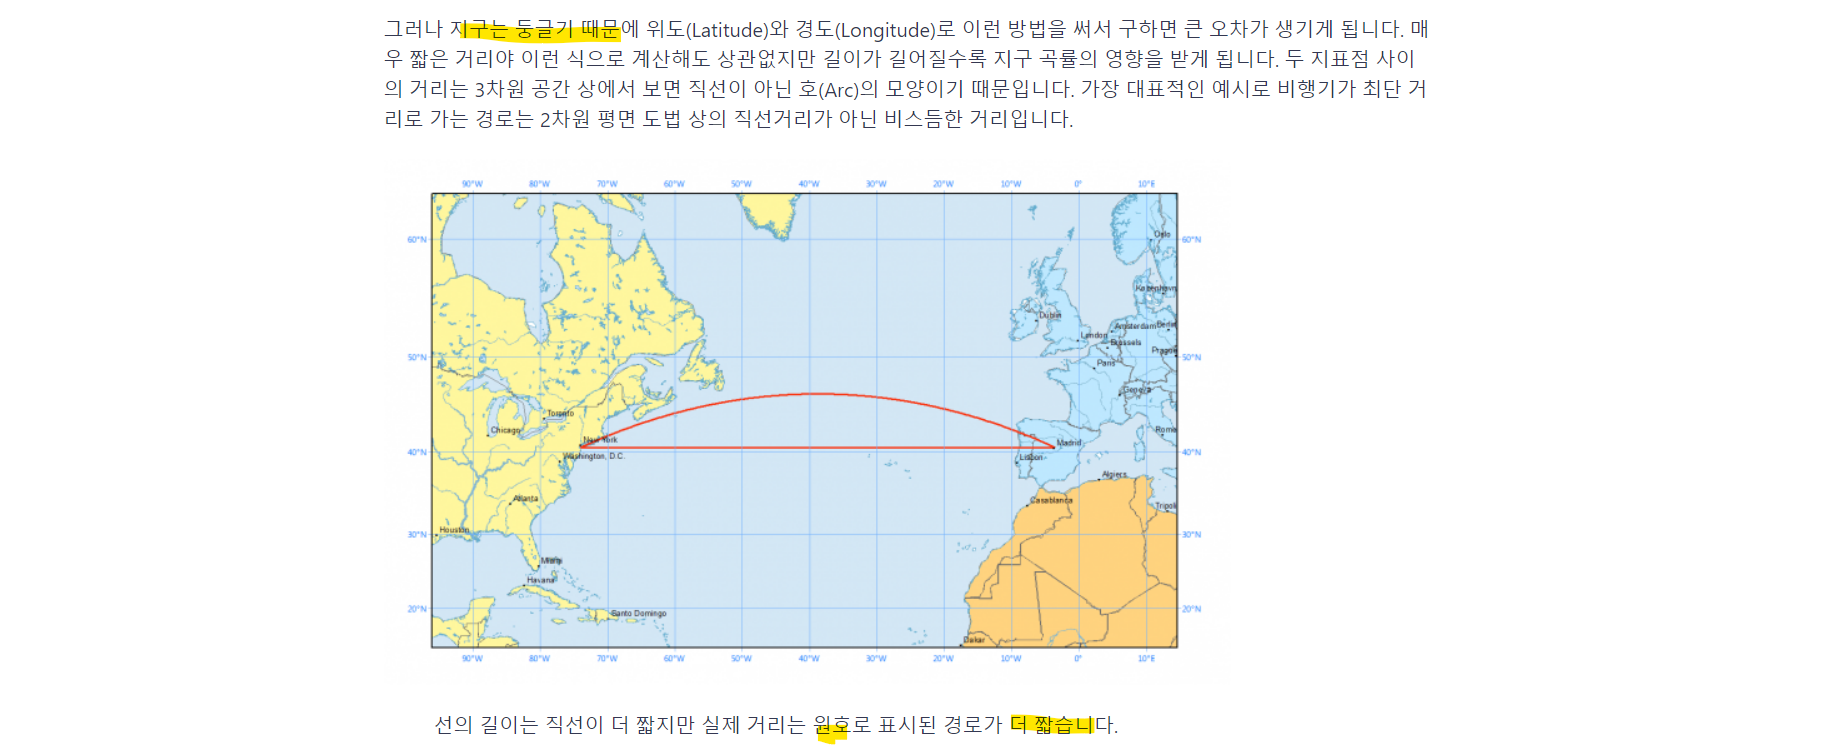

In [10]:
# 위도/경도/거리 -> 라디안 위도/경도/거리 -> 하버사인공식으로 거리를 바꾼다.
def calculateDistance(row):
    # 라디안 위도/경도로 변환
    R=6373.0 # approximate radius of earth in km
    pickup_lat=radians(row['pickup_latitude'])
    pickup_lon=radians(row['pickup_longitude'])
    dropoff_lat=radians(row['dropoff_latitude'])
    dropoff_lon=radians(row['dropoff_longitude'])
    
    # 라디안 거리
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    
    # 하버사인 거리
    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [11]:
train['trip_distance']=train.apply(lambda row:calculateDistance(row),axis=1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [12]:
train['trip_duration_in_hour']=train['trip_duration'].apply(lambda x:x/3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


### Exploratory Analysis


Text(0.5, 0, 'Trip Duration (in hour)')

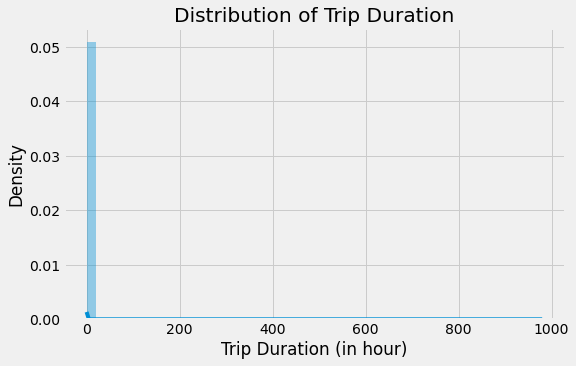

In [13]:
plt.figure(figsize=(8,5))
sns.distplot(train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel("Trip Duration (in hour)")

24시간을 초과하는 트립 기간이 있습니다. 이거 조사해야 돼요?


In [14]:
outlier_trip_duration=train.loc[train['trip_duration_in_hour']>24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


여행 시간은 매우 높지만 여행 거리는 매우 낮은 4개의 기록이 있습니다.
이것들은 특이치입니다. 하지만 이 여행이 시작되거나 끝나는 특별한 장소가 있나요?
여행 지속시간도 왜곡되어 있으므로 로그 변환을 수행하겠습니다.

이러한 데이터도 테스트 데이터의 일부일 수 있으므로 분석에서 제거하지 않습니다.

Text(0.5, 1.0, 'Distribution of trip duration (sec) in Log Scale')

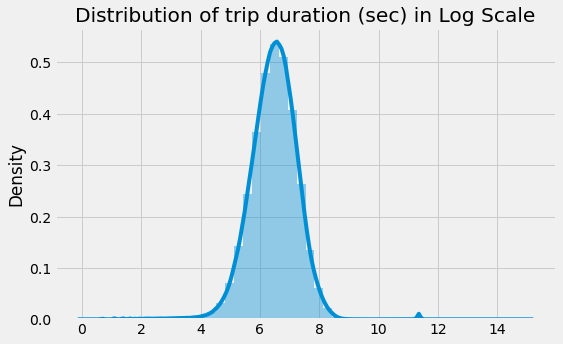

In [15]:
plt.figure(figsize=(8,5))
sns.distplot(np.log(train['trip_duration'].values)).set_title("Distribution of Trip Duration")
plt.title("Distribution of trip duration (sec) in Log Scale")

여행 기간의 로그 변환은 정규 분포를 따릅니다. 대부분의 트립은 54초(exp(4) ~ 2980초(exp(8)) 사이입니다.
이것은 대부분의 여행이 1시간 이내임을 나타냅니다. 하지만 1분도 안 되어 자세히 살펴봐야 하는 여행도 있습니다. 100시간 동안 가는 여행도 있는데, 택시도 뉴욕 안에 있어서 이상해요.

####  Heatmap of common locations from where pickup and dropoff occurs3
픽업 및 하차가 발생하는 공통 위치의 열 지도입니다.


In [16]:
pickup=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})
pickup

,pickup_latitude_round3,pickup_longitude_round3,Num_Trips
0,34.360,-65.848,1
1,34.712,-75.354,1
2,35.082,-71.800,1
3,35.310,-72.074,1
4,36.029,-77.441,1
...,...,...,...
13019,43.140,-72.591,1
13020,43.487,-74.195,1
13021,43.912,-71.882,1
13022,44.372,-66.972,1


In [17]:
pickup['Num_Trips'] = pickup['Num_Trips'].astype('float64')

pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)
hm_wide = HeatMap(list(zip(pickup['pickup_latitude_round3'].values,
                           pickup['pickup_longitude_round3'].values, 
                           pickup['Num_Trips'].values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1)

pickup_map.add_child(hm_wide)
pickup_map

(-74.03, -73.75)

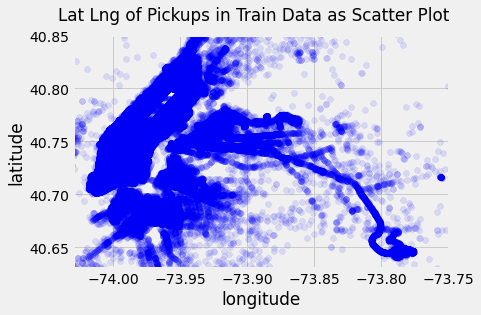

In [18]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
              color='blue', label='train', alpha=0.1)

fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

###### This graph clearly shows heavy density of pickups near JFK

In [19]:
drop=train.groupby(['dropoff_latitude_round3','dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})
drop

,dropoff_latitude_round3,dropoff_longitude_round3,Num_Trips
0,32.181,-73.835,1
1,34.360,-65.848,1
2,35.174,-72.022,1
3,36.029,-77.441,1
4,36.119,-68.778,1
...,...,...,...
31444,43.148,-69.048,1
31445,43.487,-74.195,1
31446,43.674,-79.554,1
31447,43.912,-71.882,1


In [20]:
drop['Num_Trips'] = drop['Num_Trips'].astype('float64')
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)
#print(pickup.shape)
### For each pickup point add a circlemarker
'''
for index, row in drop.iterrows():
    
    folium.CircleMarker([row['dropoff_latitude_round3'], row['dropoff_longitude_round3']],
                        radius=3,
                        
                        color="#008000", 
                        fill_opacity=0.9
                       ).add_to(drop_map)
    count=count + 1

'''
hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips.values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1 
                 )
drop_map.add_child(hm_wide)
drop_map

Dropoff Heatmap is similar to pickup

### heatmap of trip duration, when pickup originates from a point

In [21]:
pickup=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'Avg_Trip_duration'})
pickup

,pickup_latitude_round3,pickup_longitude_round3,Avg_Trip_duration
0,34.360,-65.848,961.0
1,34.712,-75.354,875.0
2,35.082,-71.800,611.0
3,35.310,-72.074,317.0
4,36.029,-77.441,782.0
...,...,...,...
13019,43.140,-72.591,799.0
13020,43.487,-74.195,674.0
13021,43.912,-71.882,632.0
13022,44.372,-66.972,1131.0


In [22]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)


hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Avg_Trip_duration.values)),
                     min_opacity=0.2,
                     radius=7, blur=15,
                     max_zoom=1 
                 )
pickup_map.add_child(hm_wide)
pickup_map

JFK에서 출발하는 여행의 평균 여행 기간이 더 깁니다. 확대하면 맨해튼 이후 JFK 픽업이 더 긴 여행 시간을 갖는 경향이 있음을 알 수 있습니다.

### Which hours are pickup and dropoff higher?

Text(0.5, 1.0, 'Pickup Hours Distribution')

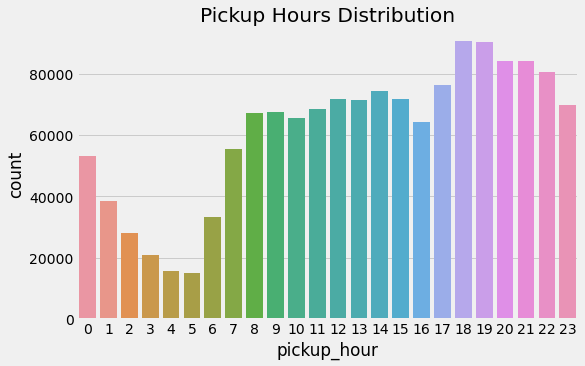

In [23]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_hour']).set_title("Pickup Hours Distribution")

픽업은 이른 아침에 훨씬 낮습니다. 대부분의 피크는 오후 6시에서 8시 사이에 가장 높습니다.


Text(0.5, 1.0, 'Dropoff Hours Distribution')

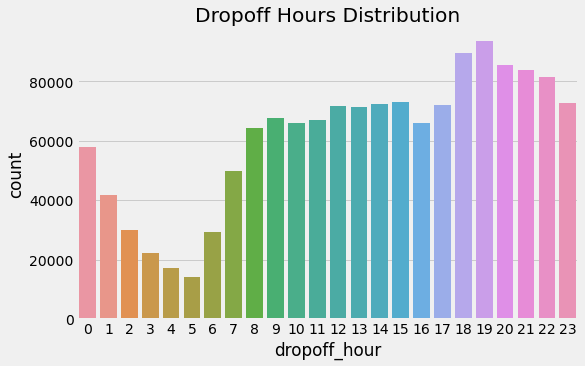

In [24]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['dropoff_hour']).set_title("Dropoff Hours Distribution")

픽업 시간과 매우 유사한 하차 시간 분포


### Pickups over the entire time period

Text(0.5, 1.0, 'Distribution of Pickups over time')

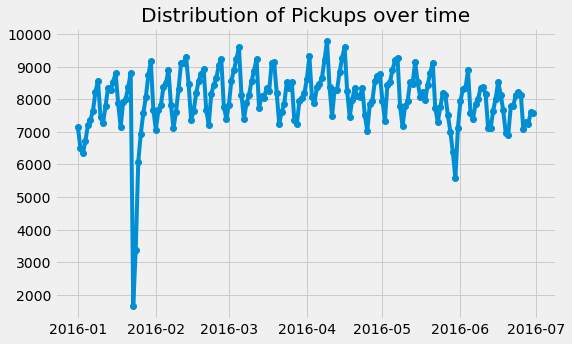

In [25]:
plt.figure(figsize=(8,5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-',label='train')


plt.title("Distribution of Pickups over time")

2016년 1월 말에 픽업 횟수가 감소했습니다.


### What is the distribution of Trip distance

Text(0.5, 0, 'Trip Distance (log)')

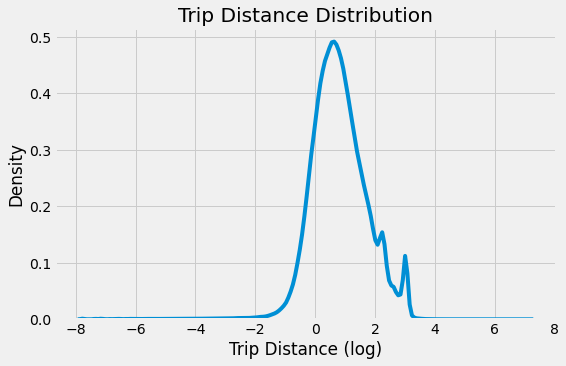

In [26]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
plt.xlabel("Trip Distance (log)")

### Trip Duration vs Trip Distance

Text(0, 0.5, 'Trip Duration (log scale)')

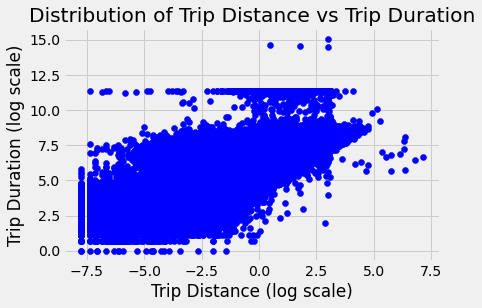

In [27]:
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values),
              color='blue', label='train')
plt.title("Distribution of Trip Distance vs Trip Duration")
plt.xlabel("Trip Distance (log scale)")
plt.ylabel("Trip Duration (log scale)")

### Is the trip duration higher at different hours?

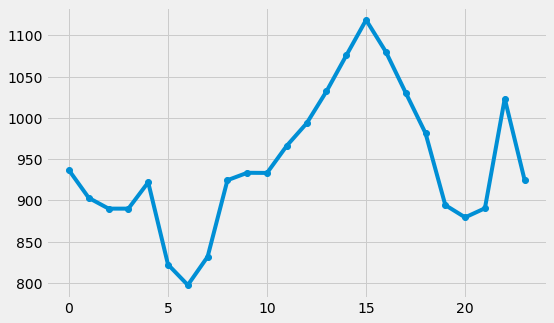

In [28]:
avg_duration_hour=train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(),'o-')

Trip duration increases between 10 to 15 hours. 

### Distribution of Pickups across Days


<AxesSubplot:xlabel='pickup_day_of_week', ylabel='count'>

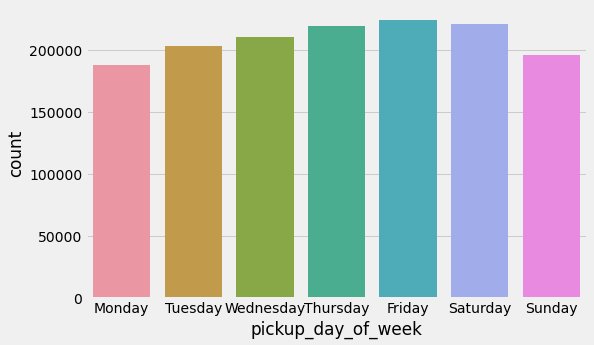

In [29]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_day_of_week'],order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])

월요일 픽업 횟수가 매우 적습니다.화요일부터 금요일까지 픽업 횟수가 계속 증가합니다.


### Avg Trip Duration over Days of week

In [30]:
avg_duration_day=train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
avg_duration_day

,pickup_day_of_week,avg_trip_duration
0,Friday,990.224200
1,Monday,897.947839
2,Saturday,948.051175
3,Sunday,901.639395
4,Thursday,1006.528654
5,Tuesday,983.463124
6,Wednesday,975.450494


Text(0.5, 1.0, 'Avg Trip Duration vs Pickup Days of Week')

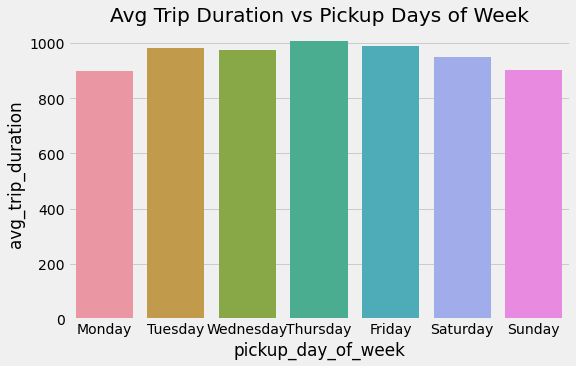

In [31]:
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week', y='avg_trip_duration', data=avg_duration_day,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Trip Duration vs Pickup Days of Week")

The highest average speed is on Thursday

### Create a caluclated field Bearing 

Bearing measures the direction of travel
The formula is:
    θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ )
    λ is the longitude

In [32]:
def calculateBearing(lat1,lng1,lat2,lng2):
    R = 6371 
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [33]:
train['bearing']=train.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)

### Distribution of Bearing

<AxesSubplot:xlabel='bearing', ylabel='Density'>

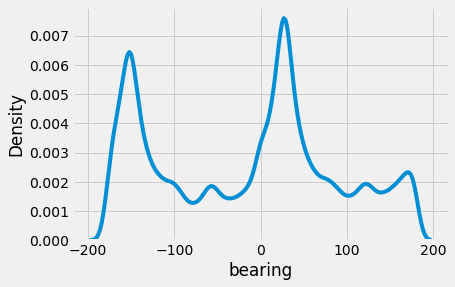

In [34]:
sns.kdeplot(train['bearing'])

### Bearing vs Trip Duration

Text(0, 0.5, 'Trip Duration (log scale)')

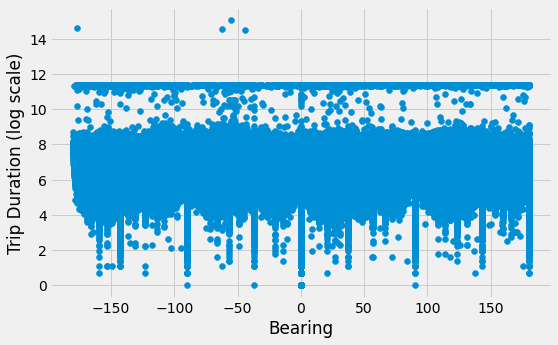

In [35]:
plt.figure(figsize=(8,5))
plt.scatter(train['bearing'].values,y=np.log(train['trip_duration'].values))
plt.xlabel("Bearing")
plt.ylabel("Trip Duration (log scale)")

여행 기간의 이상치는 모두 베어링 -50도입니다.


### Distribution of Store and FWD Flag

In [36]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

Text(0, 0.5, 'Density')

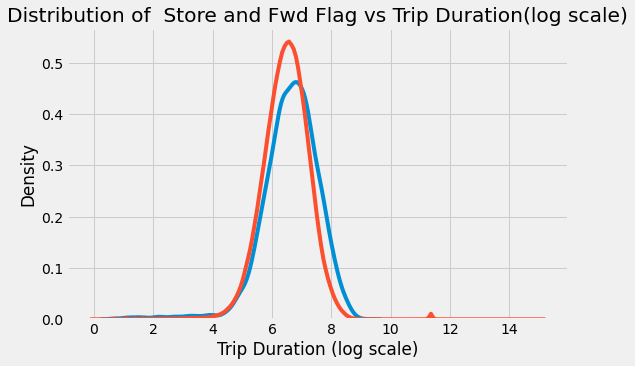

In [37]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='Y','trip_duration'].values),label= 'Store and Fwd =Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='N','trip_duration'].values),label= 'Store and Fwd =No')
   
plt.title("Distribution of  Store and Fwd Flag vs Trip Duration(log scale)")
plt.xlabel('Trip Duration (log scale)')
plt.ylabel('Density')

### Group Locations into cluster

이것은 이웃을 만드는 데 도움이 될 것입니다. 특정 동네에서 픽업하는 경우 이동 시간이 더 길어질 수 있습니다.


In [38]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))
coords

array([[ 40.76793671, -73.98215485],
       [ 40.73856354, -73.98041534],
       [ 40.7639389 , -73.97902679],
       ...,
       [ 40.74866486, -73.87660217],
       [ 40.89178848, -73.85426331],
       [ 40.76937866, -73.96932983]])

(-74.03, -73.75)

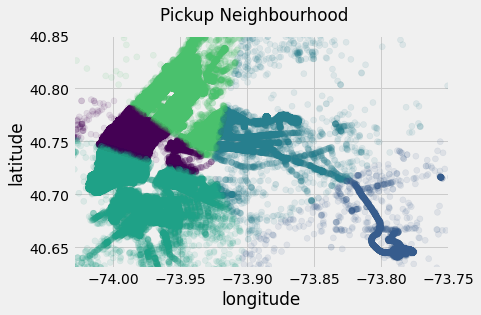

In [39]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords)

train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])

city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
              c=train['pickup_neighbourhood'], label='train', alpha=0.1)

fig.suptitle('Pickup Neighbourhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

### Number of pickups in each neighbourhood

Text(0.5, 1.0, 'Distribution of Number of Pickups across Neighbourhoods')

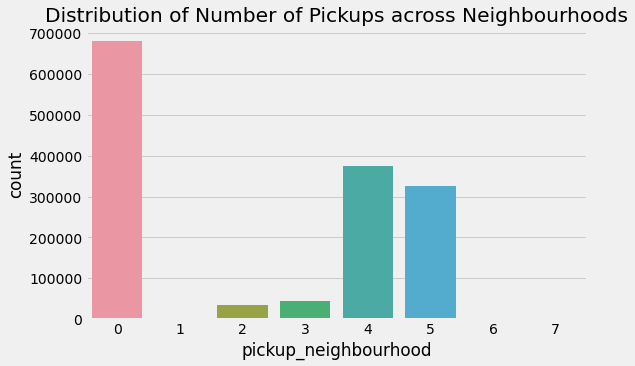

In [40]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_neighbourhood']).set_title("Distribution of Number of Pickups across Neighbourhoods")

Text(0.5, 1.0, 'Avg Trip Duration vs Neighbourhood')

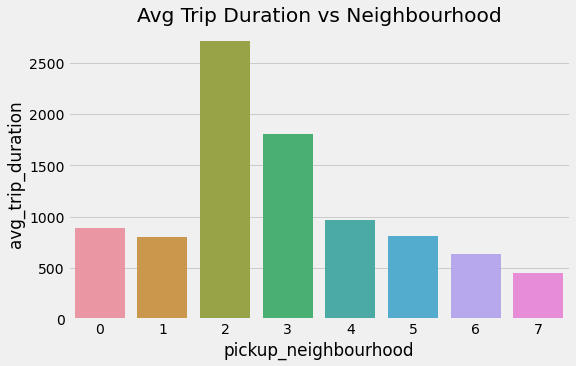

In [41]:
avg_duration_neighbourhood=train.groupby(['pickup_neighbourhood'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_neighbourhood',y='avg_trip_duration',data=avg_duration_neighbourhood).set_title("Avg Trip Duration vs Neighbourhood")

이웃 2는 평균 이동 시간이 매우 길지만 이웃 0에는 대부분의 픽업이 있습니다.


### Distribution of Average speed

Text(0.5, 1.0, 'Distribution of Average Speed (in kph)')

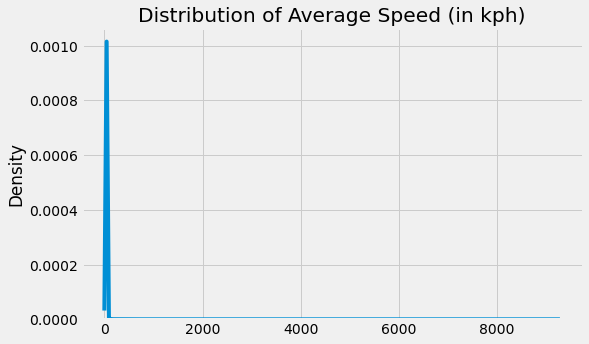

In [42]:
train['avg_speed_kph']=train['trip_distance']/train['trip_duration_in_hour']
plt.figure(figsize=(8,5))
sns.kdeplot(train['avg_speed_kph'].values).set_title("Distribution of Average Speed (in kph)")

In [43]:
print("Average speed is",np.mean(train['avg_speed_kph']),"kph") #The average speed is 14 kmph

Average speed is 14.427736738458675 kph


### Average Speed across days of week - this is indication of traffic speed.


Text(0.5, 1.0, 'Avg Speed (kph) vs Pickup Days of Week')

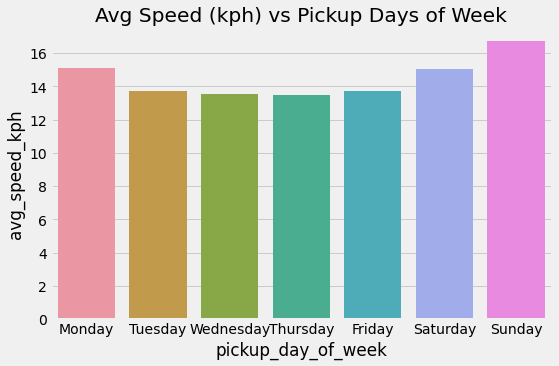

In [44]:
avg_speed_per_day=train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week',y='avg_speed_kph',data=avg_speed_per_day,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Speed (kph) vs Pickup Days of Week")

The average speed is higher on sunday and monday. 

### Feature Engineering on Test Data

In [45]:
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
#test['dropoff_datetime']=pd.to_datetime(test['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
#test['dropoff_date']= test['dropoff_datetime'].dt.date
#test['dropoff_day']=test['dropoff_datetime'].apply(lambda x:x.day)
#test['dropoff_hour']=test['dropoff_datetime'].apply(lambda x:x.hour)
#test['dropoff_day_of_week']=test['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_latitude_round3']=test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3']=test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3']=test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3']=test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance']=test.apply(lambda row:calculateDistance(row),axis=1)
#test['trip_duration_in_hour']=test['trip_duration'].apply(lambda x:x/3600)
test['bearing']=test.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)
test.loc[:, 'pickup_neighbourhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

### Building Models

교육 데이터에서 "dropoff datetime 기능"을 삭제해야 합니다. 우리는 또한 lat lng을 소수점 3자리로 반올림해서 보관합니다.


In [46]:
drop_cols=['avg_speed_kph','trip_duration_in_hour','dropoff_date','dropoff_day','dropoff_hour','dropoff_day_of_week','dropoff_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
training=train.drop(drop_cols,axis=1)
testing=test.drop(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],axis=1)

우리는 trip_duration을 예측해야 합니다. 로그 척도로 변환하고 예측합니다.


In [47]:
training['log_trip_duration']=training['trip_duration'].apply(lambda x:np.log(x))
training.drop(['trip_duration'],axis=1,inplace=True)

In [48]:
print("Training Data Shape ",training.shape)
print("Testing Data Shape ",testing.shape)

Training Data Shape  (1458644, 18)
Testing Data Shape  (625134, 17)


또한 요일을 숫자로 인코딩합니다.


In [49]:
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]

In [50]:
training['pickup_day_of_week']=training['pickup_day_of_week'].apply(lambda x:encodeDays(x))
testing['pickup_day_of_week']=testing['pickup_day_of_week'].apply(lambda x:encodeDays(x))

In [51]:
training.to_csv("input_training.csv",index=False)
testing.to_csv("input_testing.csv",index=False)
del training
del testing
del train
del test

In [52]:
def LabelEncoding(train_df,test_df,max_levels=2):
    for col in train_df:
        if train_df[col].dtype == 'object':
            if len(list(train_df[col].unique())) <= max_levels:
                le = preprocessing.LabelEncoder()
                le.fit(train_df[col])
                train_df[col]=le.transform(train_df[col])
                test_df[col]=le.transform(test_df[col])
    return [train_df,test_df]
                

def readInputAndEncode(input_path, train_file, test_file, target_column):
    training = pd.read_csv(input_path+train_file)
    testing = pd.read_csv(input_path+test_file)
   
    training, testing = LabelEncoding(training, testing)
    
    #print("Training Data Shape after Encoding ",training.shape)
    #print("Testing Data Shape after Encoding ",testing.shape)
    #Check if all train columns are there in test data. If not add the column to test data and replace it with zero
    train_cols = training.columns.tolist()
    test_cols = testing.columns.tolist()
    col_in_train_not_test = set(train_cols)-set(test_cols)
    for col in col_in_train_not_test:
        if col != target_column:
            testing[col] = 0
            
    col_in_test_not_train = set(test_cols)-set(train_cols)
    
    for col in col_in_test_not_train:
        training[col] = 0
        
    print("Training Data Shape after Processing ", training.shape)
    print("Testing Data Shape after Processing ", testing.shape)
    return [training,testing]

In [53]:
train, test = readInputAndEncode("", 'input_training.csv', 'input_testing.csv', 'log_trip_duration')
train.drop(['pickup_date'],axis=1,inplace=True)
test.drop(['pickup_date'],axis=1,inplace=True)
train.drop(['pickup_datetime'],axis=1,inplace=True)
test.drop(['pickup_datetime'],axis=1,inplace=True)

test_id=test['id']
train.drop(['id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

Training Data Shape after Processing  (1458644, 18)
Testing Data Shape after Processing  (625134, 17)


In [54]:
def GetFeaturesAndSplit(train, test, target, imputing_strategy='median', split=0.25, imputation=True):
    labels = np.array(train[target]) # train['log_trip_duration']
    training = train.drop(target, axis = 1)
    training = np.array(training)
    testing = np.array(test)
    
    if imputation==True:
        imputer=Imputer(strategy=imputing_strategy,missing_values=np.nan)
        imputer.fit(training)
        training=imputer.transform(training)
        testing=imputer.transform(testing)
        
    train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size = split, random_state = 42)
    return [train_features,validation_features,train_labels,validation_labels,testing]

In [55]:
train_features, validation_features, train_labels, validation_labels, testing = GetFeaturesAndSplit(train, test, 
                                                                                                    'log_trip_duration',
                                                                                                    imputation=False)

In [57]:
train.head()

,vendor_id,passenger_count,store_and_fwd_flag,pickup_day,pickup_hour,pickup_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,bearing,pickup_neighbourhood,dropoff_neighbourhood,log_trip_duration
0,2,1,0,14,17,1,40.768,-73.982,40.766,-73.965,1.498991,98.823984,0,5,6.120297
1,1,1,0,12,0,0,40.739,-73.980,40.731,-73.999,1.806074,-119.053505,0,4,6.496775
2,2,1,0,19,11,2,40.764,-73.979,40.710,-74.005,6.387103,-159.948291,0,4,7.661056
3,2,1,0,6,19,3,40.720,-74.010,40.707,-74.012,1.485965,-173.347990,4,4,6.061457
4,2,1,0,26,13,6,40.793,-73.973,40.783,-73.973,1.188962,180.000000,5,5,6.075346


#### Apply Linear Regression

In [63]:
lm = linear_model.LinearRegression()
lm.fit(train_features, train_labels)

LinearRegression()

In [64]:
valid_pred = lm.predict(validation_features)

In [65]:
rmse = mean_squared_error(validation_labels, valid_pred)
print("Root Mean Squared Error for Linear Regression(log scale) ",rmse)

Root Mean Squared Error for Linear Regression(log scale)  0.4031176249688167


In [66]:
test_pred = lm.predict(testing)
submit = pd.DataFrame()
submit['id'] = test_id
submit['trip_duration'] = np.exp(test_pred)
submit.to_csv("submission_linear_regression_baseline.csv",index=False) #0.64221 on Leader board
del submit

#### Apply Random Forest Regressor

In [67]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

In [68]:
rf.fit(train_features, train_labels)

RandomForestRegressor(random_state=42)

In [69]:
valid_pred_rf = rf.predict(validation_features)
rmse = mean_squared_error(validation_labels, valid_pred_rf)
print("Root Mean Squared Error for Random Forest",rmse)

Root Mean Squared Error for Random Forest 0.1658653809014289


In [70]:
test_pred = rf.predict(testing)
submit = pd.DataFrame()
submit['id'] = test_id
submit['trip_duration'] = np.exp(test_pred)
submit.to_csv("submission_random_forest_baseline.csv", index=False)